In [1]:
%matplotlib inline
import random
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import t
from statistics import mean
from statistics import stdev

M = 10000

rpm = np.random.triangular(1500, 1650, 1800, M) #Cederberg (2023)

f = (83.6 / 0.95 / 0.9 / 0.8) / 110 #ratio between P_engineOut (diesel/hybrid) and P_batteriesOut (a.k.a. P_cons) --
                                    #-- calculated for P_cons = 110 kW
    
t_b = np.random.triangular(8, 10, 12, M) #years, battery lifetime
t_f = 25 #years, ferry lifetime

FC = np.random.triangular(25, 35, 45,M)
P_cons = np.random.triangular(80, 110, 140, M)
P_consICE = f * P_cons
MK1_hv = 35.3

#SMED, 2020 values:
SO2 = 36.0
PM = np.random.triangular(0.6 * 0.27, 0.27, 1.4 * 0.27)  #g / GJ, PM uncertainty: 40%

#CO2_battery: 
#Lower bound value (LBV): 172
#Asymptotic value (ASV): 240
#"Average value" (AVV): 487

#Battery production:
CO2_battery = np.random.triangular(140, 240, 487, M) #kg CO2 eq. / kWh

#Energimyndigheten, 2021 values:
CO2 = 2580 #g CO2 eq. / liter
HVO = 520  #g CO2 eq. / liter

#Electricity mix:
CO2_e = 30 #g CO2 eq. / kWh

#Engine production:
CO2_engine = 37.75 #kg CO2 eq. / kW
kW_engine = 257

#Electric motor production:
CO2_motor = 19.6 #kg CO2 eq. / kW, assumed same kW as engines

#MGO production:
CO2_fuel = 12.5 #kg CO2 eq. / MJ

In [2]:

#IMO Regulation 13:

def TierII_NOX(rpm):
    return 44*pow(rpm,-0.23) #g / kWh

def TierIII_NOX(rpm):
    return 9*pow(rpm,-0.2)

#CO2, SO2 and PM functions:

def CO2_calc(t_op, e_f):
    CO2_ret = CO2 * FC * t_op * (1 - e_f)  #Diesel part
    CO2_ret += CO2_e * P_cons * t_op * e_f #Electricity part
    return CO2_ret

def SO2_calc(t_op, e_f):
    SO2_ret = SO2 * FC * (MK1_hv / 1000) * t_op * (1 - e_f)
    return SO2_ret
                                    
def PM_calc(t_op, e_f):
    PM_ret = PM * FC * (MK1_hv / 1000) * t_op * (1 - e_f)
    return PM_ret 
                                              
def emissionCalc(t_op, e_f, tier, rpm): 
    
    CO2_result = CO2_calc(t_op, e_f)
    SO2_result = SO2_calc(t_op, e_f)
    PM_result = PM_calc(t_op, e_f)
    
    #NOx emissions:        
    if tier == 2:
        NOX_result = TierII_NOX(rpm) * P_consICE * t_op * (1 - e_f)
        #print(NOX_result)
    elif tier == 3:
        NOX_result = TierIII_NOX(rpm) * P_consICE * t_op * (1 - e_f)
    else:
        print("Incompatible tier")
      
    return [CO2_result, NOX_result, SO2_result, PM_result]

def summary4(f1,f2,f3,f4):
    
    res = np.array([f1, f2, f3, f4]) / 1000
    res = res.sum(axis=0)
    
    #print("GHGs: " + str(f'{res[0]:.5f}'))
    #print("NOx: " + str(f'{res[1]:.5f}'))
    #print("SOx: " + str(f'{res[2]:.5f}'))
    #print("PM: " + str(f'{res[3]:.5f}'))
    return res

def summary5(f1,f2,f3,f4,f5):
   
    res = np.array([f1,f2,f3,f4,f5]) / 1000
    res = res.sum(axis=0)
    
    #print("GHGs: " + str(f'{res[0]:.5f}'))
    #print("NOx: " + str(f'{res[1]:.5f}'))
    #print("SOx: " + str(f'{res[2]:.5f}'))
    #print("PM: " + str(f'{res[3]:.5f}'))
    return res
    
def upstreamCalc(f, kWh_init, kWh, kW, t_op, e_f):
    for i in range(M):
        #f[0][i] += (((CO2_battery[i] * kWh) / (t_b[i] * 365)) + ((CO2_engine * kW) / (t_f * 365))) * 1000
    #f += (((CO2_battery * kWh) / (t_b * 365)) + ((CO2_engine * kW) / (t_f * 365))) * 1000
    
        #f[0][i] += ((CO2_battery[i] * kWh) / (t_b[i] * 365)) * 1000 #Battery production
        
        #Battery production: The initial capacity + the replacements 
        f[0][i] +=  (CO2_battery[i] * (kWh_init + (kWh * (t_f / t_b[i])))) / (t_f * 365) * 1000 
        #Engine production:
        f[0][i] += ((CO2_engine * kW) / (t_f * 365)) * 1000 
        #Electric motor production: All ferries have two electric motors, assumed to have the same kW as the engines
        f[0][i] += ((2 * kW_engine * CO2_motor) / (t_f * 365)) / 1000     
        #Fuel production:
        f[0][i] += ((t_op * (1 - e_f) * FC[i] * MK1_hv * CO2_fuel) / (t_f * 365)) * 1000 
    
    return f #grams

In [3]:
#BASELINE
t_op1 = 13
t_op2 = 12.5
t_op3 = 8

e_f1 = 0.6154
e_f2 = 0.5200
e_f3 = 0

ferry1 = emissionCalc(t_op1, e_f1, 3, 1650)
ferry2 = emissionCalc(t_op2, e_f2, 3, 1650)
ferry3 = emissionCalc(t_op3, e_f3, 2, 1650) #returns grams / day
ferry4 = A = [[0 for col in range(M)] for row in range(4)]

opPartBase = (ferry1[0] + ferry2[0] + ferry3[0]) / 1000  #kilograms / day, operational part of GHG emissions

ferry1 = upstreamCalc(ferry1, 1260, 1260, kW_engine, t_op1, e_f1) #returns grams / day
ferry2 = upstreamCalc(ferry2, 1000, 1000, kW_engine, t_op2, e_f2)
ferry3 = upstreamCalc(ferry3, 0, 0, 2 * kW_engine, t_op3, e_f3)
ferry4 = upstreamCalc(ferry4, 0, 0, 2 * kW_engine, 0, 0)

#BASE_GHG = summary4(ferry1[0],ferry2[0],ferry3[0],ferry4[0]) #returns kilograms / day
GHG_BASE = [0 for col in range(M)]
NOX_BASE = [0 for col in range(M)]
SO2_BASE = [0 for col in range(M)]
PM_BASE = [0 for col in range(M)]


for i in range(M):
    GHG_BASE[i] = (ferry1[0][i] + ferry2[0][i] + ferry3[0][i] + ferry4[0][i]) / 1000

for i in range(M):
    NOX_BASE[i] = (ferry1[1][i] + ferry2[1][i] + ferry3[1][i]) / 1000
    
for i in range(M):
    SO2_BASE[i] = (ferry1[2][i] + ferry2[2][i] + ferry3[2][i]) / 1000 
      
for i in range(M):
    PM_BASE[i] = (ferry1[3][i] + ferry2[3][i] + ferry3[3][i]) / 1000

#print(GHG)
#print(NOX)
#print(SO2)
#print(PM)


In [4]:
#Big Battery
t_op1 = 11
t_op2 = 10.5
t_op3 = 9
t_op4 = 3

e_f1 = 1
e_f2 = 1
e_f3 = 1
e_f4 = 1

ferry1 = emissionCalc(t_op1, e_f1, 3, 1650)
ferry2 = emissionCalc(t_op2, e_f2, 3, 1650)
ferry3 = emissionCalc(t_op3, e_f3, 3, 1650)
ferry4 = emissionCalc(t_op4, e_f4, 3, 1650)

opPartBB = (ferry1[0] + ferry2[0] + ferry3[0]) / 1000

ferry1 = upstreamCalc(ferry1, 1260, 1260, kW_engine, 0, 0)
ferry2 = upstreamCalc(ferry2, 1260, 1260, kW_engine, 0, 0)
ferry3 = upstreamCalc(ferry3, 1260, 1260, kW_engine, 0, 0)
ferry4 = upstreamCalc(ferry4, 1000, 1000, kW_engine, 0, 0)

GHG_BB = [0 for col in range(M)]

for i in range(M):
    GHG_BB[i] = (ferry1[0][i] + ferry2[0][i] + ferry3[0][i] + ferry4[0][i]) / 1000



In [5]:
#Optimize Battery
t_op1 = 8
t_op2 = 8.5
t_op3 = 9
t_op4 = 8

e_f1 = 1
e_f2 = 1
e_f3 = 1
e_f4 = 1

ferry1 = emissionCalc(t_op1, e_f1, 3, 1650)
ferry2 = emissionCalc(t_op2, e_f2, 3, 1650)
ferry3 = emissionCalc(t_op3, e_f3, 3, 1650)
ferry4 = emissionCalc(t_op4, e_f4, 3, 1650)

opPartOBS = (ferry1[0] + ferry2[0] + ferry3[0] + ferry4[0]) / 1000

ferry1 = upstreamCalc(ferry1, 1260, 670, kW_engine, 0, 0)
ferry2 = upstreamCalc(ferry2, 1000, 670, kW_engine, 0, 0)
ferry3 = upstreamCalc(ferry3, 670, 670, kW_engine, 0, 0)
ferry4 = upstreamCalc(ferry4, 670, 670, kW_engine, 0, 0)

GHG_OBS = [0 for col in range(M)]

for i in range(M):
    GHG_OBS[i] = (ferry1[0][i] + ferry2[0][i] + ferry3[0][i] + ferry4[0][i]) / 1000



In [6]:
#Wireless Steady SoC
t_op1 = 8.375
t_op2 = 8.375
t_op3 = 8.375
t_op4 = 8.375

e_f1 = 1
e_f2 = 1
e_f3 = 1
e_f4 = 1

ferry1 = emissionCalc(t_op1, e_f1, 3, 1650)
ferry2 = emissionCalc(t_op2, e_f2, 3, 1650)
ferry3 = emissionCalc(t_op3, e_f3, 3, 1650)
ferry4 = emissionCalc(t_op4, e_f4, 3, 1650)

opPartWS = (ferry1[0] + ferry2[0] + ferry3[0]) / 1000

ferry1 = upstreamCalc(ferry1, 130, 130, kW_engine, 0, 0)
ferry2 = upstreamCalc(ferry2, 130, 130, kW_engine, 0, 0)
ferry3 = upstreamCalc(ferry3, 130, 130, kW_engine, 0, 0)
ferry4 = upstreamCalc(ferry4, 130, 130, kW_engine, 0, 0)

GHG_WS = [0 for col in range(M)]

for i in range(M):
    GHG_WS[i] = (ferry1[0][i] + ferry2[0][i] + ferry3[0][i] + ferry4[0][i]) / 1000


In [7]:
#Wireless Falling SoC
t_op1 = 8.375
t_op2 = 8.375
t_op3 = 8.375
t_op4 = 8.375

e_f1 = 1
e_f2 = 1
e_f3 = 1
e_f4 = 1

ferry1 = emissionCalc(t_op1, e_f1, 3, 1650)
ferry2 = emissionCalc(t_op2, e_f2, 3, 1650)
ferry3 = emissionCalc(t_op3, e_f3, 3, 1650)
ferry4 = emissionCalc(t_op4, e_f4, 3, 1650)

opPartWF = (ferry1[0] + ferry2[0] + ferry3[0]) / 1000

ferry1 = upstreamCalc(ferry1, 539, 539, kW_engine, 0, 0)
ferry2 = upstreamCalc(ferry2, 539, 539, kW_engine, 0, 0)
ferry3 = upstreamCalc(ferry3, 539, 539, kW_engine, 0, 0)
ferry4 = upstreamCalc(ferry4, 539, 539, kW_engine, 0, 0)

GHG_WF = [0 for col in range(M)]

for i in range(M):
    GHG_WF[i] = (ferry1[0][i] + ferry2[0][i] + ferry3[0][i] + ferry4[0][i]) / 1000



[1697.98304348 2397.23001527]


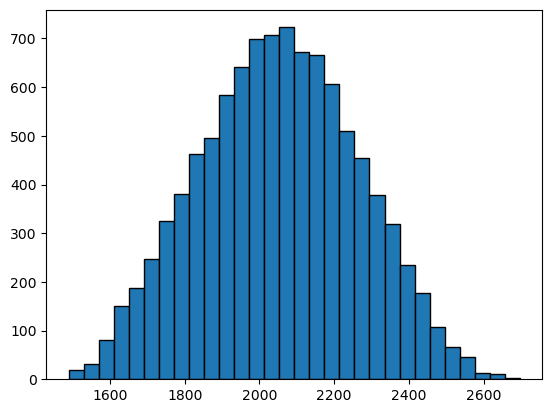

In [8]:
plt.hist(GHG_BASE, bins = 30, ec = 'black')
GHG_BASE_percentile = np.percentile(GHG_BASE, [5, 95])
print(GHG_BASE_percentile)

[442.61247001 897.57624881]


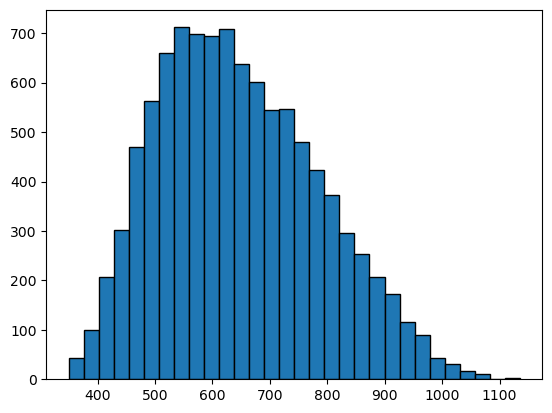

In [9]:
plt.hist(GHG_BB, bins = 30, ec = 'black')
GHG_BB_percentile = np.percentile(GHG_BB, [5, 95])
print(GHG_BB_percentile)

[315.60881179 596.05946649]


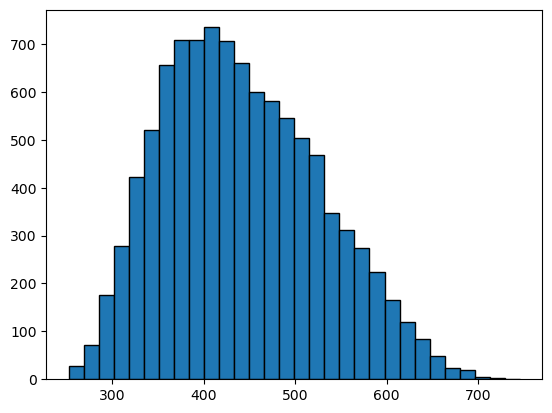

In [10]:
plt.hist(GHG_OBS, bins = 30, ec = 'black')
GHG_OBS_percentile = np.percentile(GHG_OBS, [5, 95])
print(GHG_OBS_percentile)

[141.53100606 205.59668734]


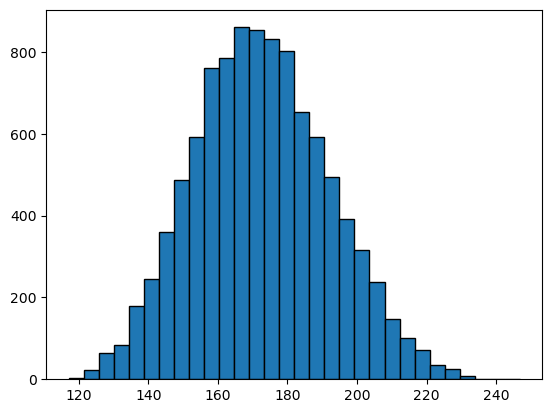

In [11]:
plt.hist(GHG_WS, bins = 30, ec = 'black')
GHG_WS_percentile = np.percentile(GHG_WS, [5, 95])
print(GHG_WS_percentile)

[260.84839929 468.3676162 ]


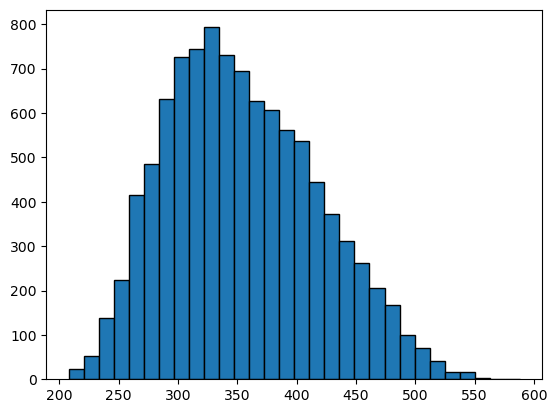

In [12]:
plt.hist(GHG_WF, bins = 30, ec = 'black')
GHG_WF_percentile = np.percentile(GHG_WF, [5, 95])
print(GHG_WF_percentile)

[ 8.58702013 12.549533  ]


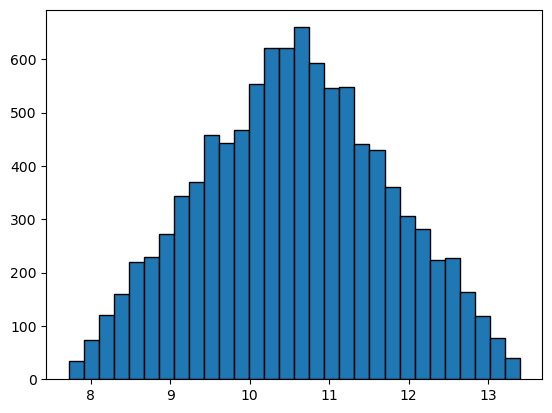

In [13]:
plt.hist(NOX_BASE, bins = 30, ec = 'black')
NOX_BASE_percentile = np.percentile(NOX_BASE, [5, 95])
print(NOX_BASE_percentile)

[0.67896126 1.00819527]


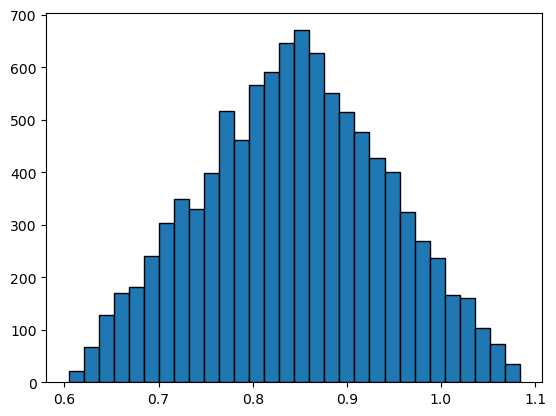

In [14]:
plt.hist(SO2_BASE, bins = 30, ec = 'black')
SO2_BASE_percentile = np.percentile(SO2_BASE, [5, 95])
print(SO2_BASE_percentile)

[0.00459964 0.00683005]


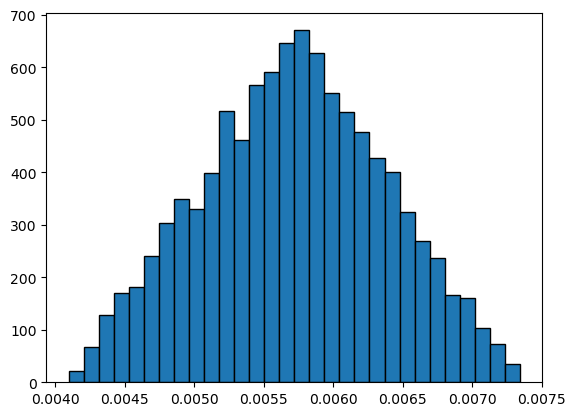

In [15]:
plt.hist(PM_BASE, bins = 30, ec = 'black')
PM_BASE_percentile = np.percentile(PM_BASE, [5, 95])
print(PM_BASE_percentile)